In [8]:
from pyspark.sql import SparkSession
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T

from pyspark.ml import Pipeline
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF, StopWordsRemover
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from nltk.corpus import stopwords
import re as re

from pyspark.ml.linalg import Vector, Vectors, SparseVector
from pyspark.ml.clustering import LDA, LDAModel, KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.mllib.feature import Word2Vec, Word2VecModel

from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [3]:
%%capture
spark = sparknlp.start()

In [4]:
df = spark.read.csv("gs://bdp_group6_bckt_2/data/processed_data/processed_data.parquet",
                    inferSchema=True, header=True,
                    multiLine=True, quote='\"', escape='\"')
df.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- cord_uid: string (nullable = true)
 |-- source_x: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- body_text: string (nullable = false)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: string (nullable = true)



In [5]:
eng_stopwords = stopwords.words('english')

In [6]:
def create_pipeline(column, embedding_type):
    documentAssembler = DocumentAssembler() \
         .setInputCol(column) \
         .setOutputCol('document')

    tokenizer = Tokenizer() \
         .setInputCols(['document']) \
         .setOutputCol('token')

    normalizer = Normalizer() \
         .setInputCols(['token']) \
         .setOutputCol('normalized') \
         .setLowercase(True)

    stopwords_cleaner = StopWordsCleaner() \
         .setInputCols(['normalized']) \
         .setOutputCol('clean_normalized') \
         .setCaseSensitive(False) \
         .setStopWords(eng_stopwords)

    lemmatizer = LemmatizerModel.pretrained() \
         .setInputCols(['clean_normalized']) \
         .setOutputCol('lemma')
    
    stopwords_cleaner2 = StopWordsCleaner() \
         .setInputCols(['lemma']) \
         .setOutputCol('clean_lemma') \
         .setCaseSensitive(False) \
         .setStopWords(eng_stopwords)
    
    if embedding_type == "word2vec":
        embeddings = Word2VecModel.pretrained(name='word2vec_gigaword_300') \
             .setInputCols("clean_lemma") \
             .setOutputCol("embeddings")

    elif embedding_type == "healthcare":
        embeddings = BertEmbeddings.pretrained("bert_biolink_base", "en")\
             .setInputCols(["clean_lemma", "document"])\
             .setOutputCol("embeddings")
    
    sentence_embeddings = SentenceEmbeddings() \
        .setInputCols(["document", "embeddings"]) \
        .setOutputCol("sentence_embeddings") \
        .setPoolingStrategy("AVERAGE")

    finisher = EmbeddingsFinisher() \
        .setInputCols(["sentence_embeddings"]) \
        .setOutputCols(["sentence_features"]) \
        .setOutputAsVector(True) \
        .setCleanAnnotations(False)

    pipeline = Pipeline() \
         .setStages([
               documentAssembler,
               tokenizer,
               normalizer,
               stopwords_cleaner,
               lemmatizer,
               stopwords_cleaner2,
               embeddings,
               sentence_embeddings,
               finisher
         ])
    
    return pipeline

### Using word2vec embeddings

In [7]:
# Using word2vec embeddings on abstract
abstract_pipeline = create_pipeline("abstract", "word2vec")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[ | ]lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
Download done! Loading the resource.
[OK!]
word2vec_gigaword_300 download started this may take some time.
Approximate size to download 312.3 MB
[ | ]word2vec_gigaword_300 download started this may take some time.
Approximate size to download 312.3 MB
Download done! Loading the resource.
[ / ]

[ — ]

[OK!]


In [9]:
abstract_model = abstract_pipeline.fit(df)
abstract_df  = abstract_model.transform(df)

abstract_df = abstract_df.select("*", F.explode(F.col("sentence_features")).alias("features"))
abstract_df.select("paper_id", "features").show(5)

+--------+--------------------+
|paper_id|            features|
+--------+--------------------+
|PMC35282|[0.02113212645053...|
|PMC59543|[0.02166281081736...|
|PMC59549|[0.00953531265258...|
|PMC59574|[0.01586900092661...|
|PMC59580|[0.01724373362958...|
+--------+--------------------+
only showing top 5 rows



In [18]:
silhouette_scores = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(3, 8):
    print(f"------ {i} Clusters ------")
    # Train the model
    kmeans = KMeans().setK(i).setSeed(42)
    model = kmeans.fit(abstract_df)
    
    # Make predictions
    predictions = model.transform(abstract_df)
    
    # Evaluate clustering by computing Silhouette score
    silhouette = evaluator.evaluate(predictions)
    print(f"Silhouette score: {round(silhouette, 3)}")
    silhouette_scores.append(silhouette)

------ 2 Clusters ------


# Clusters: 2, Silhouette score: 0.195
------ 3 Clusters ------


# Clusters: 3, Silhouette score: 0.182
------ 4 Clusters ------


# Clusters: 4, Silhouette score: 0.117
------ 5 Clusters ------


# Clusters: 5, Silhouette score: 0.177
------ 6 Clusters ------


# Clusters: 6, Silhouette score: 0.126
------ 7 Clusters ------


# Clusters: 7, Silhouette score: 0.108
------ 8 Clusters ------


# Clusters: 8, Silhouette score: 0.102
------ 9 Clusters ------


# Clusters: 9, Silhouette score: 0.06


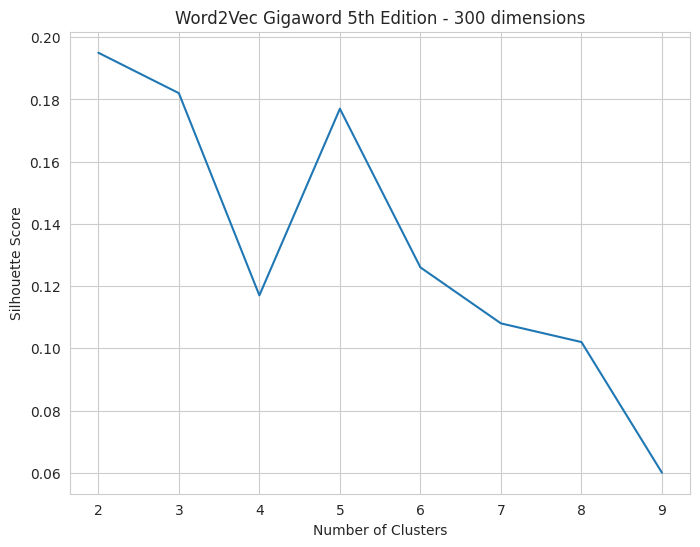

In [11]:
plt.figure(figsize=(8, 6))

sns.lineplot(x=list(range(2, 10)), y=silhouette_scores)

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("Word2Vec Gigaword 5th Edition - 300 dimensions")

plt.show()

### Using Biolink BERT base embeddings

In [12]:
# Use healtcare embeddings on abstract
abstract_pipeline_hc = create_pipeline("abstract", "healthcare")

abstract_model_hc = abstract_pipeline_hc.fit(df)
abstract_df_hc  = abstract_model_hc.transform(df)

abstract_df_hc = abstract_df_hc.select("*", F.explode(
                                                         F.col("sentence_features")
                                                     ).alias("features"))
abstract_df_hc.select("paper_id", "features").show(5)

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
bert_biolink_base download started this may take some time.
Approximate size to download 387.5 MB
[ | ]bert_biolink_base download started this may take some time.
Approximate size to download 387.5 MB
Download done! Loading the resource.
[ \ ]

[ | ]

[OK!]


In [13]:
silhouette_scores_hc = []
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2, 10):
    print(f"------ {i} Clusters ------")
    # Train the model
    kmeans = KMeans().setK(i).setSeed(42)
    model = kmeans.fit(abstract_df_hc)
    
    # Make predictions
    predictions = model.transform(abstract_df_hc)
    
    # Evaluate clustering by computing Silhouette score
    silhouette = evaluator.evaluate(predictions)
    print(f"# Clusters: {i}, Silhouette score: {round(silhouette, 3)}")
    silhouette_scores_hc.append(silhouette)

------ 2 Clusters ------


# Clusters: 2, Silhouette score: 0.102
------ 3 Clusters ------


# Clusters: 3, Silhouette score: 0.03
------ 4 Clusters ------


# Clusters: 4, Silhouette score: 0.13
------ 5 Clusters ------


# Clusters: 5, Silhouette score: 0.277
------ 6 Clusters ------


# Clusters: 6, Silhouette score: 0.137
------ 7 Clusters ------


# Clusters: 7, Silhouette score: 0.09
------ 8 Clusters ------


# Clusters: 8, Silhouette score: 0.08
------ 9 Clusters ------


# Clusters: 9, Silhouette score: 0.025


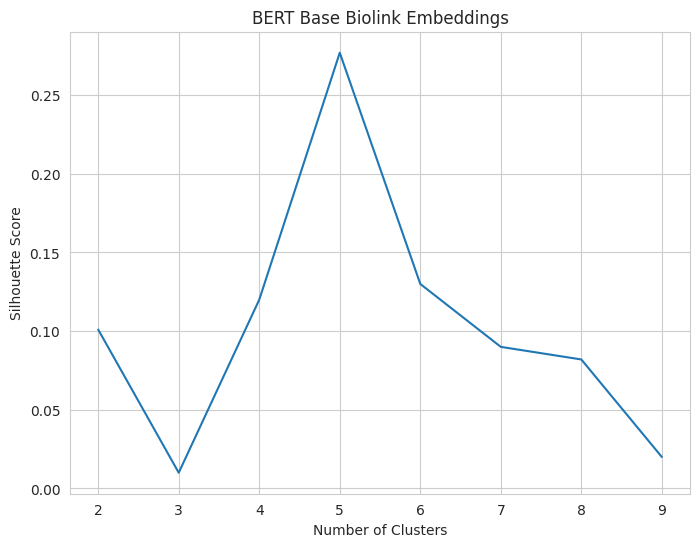

In [17]:
plt.figure(figsize=(8, 6))

sns.lineplot(x=list(range(2, 10)), y=silhouette_scores_hc)

plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.title("BERT Base Biolink Embeddings")

plt.show()